<a href="https://colab.research.google.com/github/mobarakol/tutorial_notebooks/blob/main/LlaVA_works.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install -q transformers==4.36.0
!pip install -q bitsandbytes==0.41.3 accelerate==0.25.0

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 8.2/8.2 MB 22.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.6/3.6 MB 40.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 92.6/92.6 MB 8.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 265.7/265.7 kB 30.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.3/21.3 MB 73.8 MB/s eta 0:00:00


In [ ]:
from transformers import pipeline
import torch
from transformers import BitsAndBytesConfig

quantization_config = BitsAndBytesConfig(
    load_in_4bit=True,
    bnb_4bit_compute_dtype=torch.float16
)

model_id = "llava-hf/llava-1.5-7b-hf"
pipe = pipeline("image-to-text", model=model_id, model_kwargs={"quantization_config": quantization_config})

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:88: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


config.json:   0%|          | 0.00/950 [00:00<?, ?B/s]

model.safetensors.index.json:   0%|          | 0.00/70.1k [00:00<?, ?B/s]

model-00001-of-00003.safetensors:   0%|          | 0.00/4.99G [00:00<?, ?B/s]

model-00002-of-00003.safetensors:   0%|          | 0.00/4.96G [00:00<?, ?B/s]

model-00003-of-00003.safetensors:   0%|          | 0.00/4.18G [00:00<?, ?B/s]

Loading checkpoint shards:   0%|          | 0/3 [00:00<?, ?it/s]

generation_config.json:   0%|          | 0.00/141 [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/1.33k [00:00<?, ?B/s]

tokenizer.model:   0%|          | 0.00/500k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.84M [00:00<?, ?B/s]

added_tokens.json:   0%|          | 0.00/41.0 [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/438 [00:00<?, ?B/s]

Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.


preprocessor_config.json:   0%|          | 0.00/557 [00:00<?, ?B/s]

In [ ]:

import requests
from PIL import Image

image_url = "https://llava-vl.github.io/static/images/view.jpg"
image = Image.open(requests.get(image_url, stream=True).raw)

max_new_tokens = 200
prompt = "USER: <image>\nWhat are the things I should be cautious about when I visit this place?\nASSISTANT:"
outputs = pipe(image, prompt=prompt, generate_kwargs={"max_new_tokens": 200})
print(outputs[0]["generated_text"])

USER:  
What are the things I should be cautious about when I visit this place?
ASSISTANT: When visiting this place, which is a pier or dock extending over a body of water, there are a few things to be cautious about. First, be aware of the weather conditions, as sudden changes in weather can make the pier unsafe to walk on. Second, be mindful of the water depth and any potential hazards, such as submerged rocks or debris, that could cause accidents or injuries. Additionally, be cautious of the presence of wildlife, such as birds or fish, and avoid disturbing their natural habitats. Lastly, be aware of any local regulations or guidelines for the use of the pier, as some areas may be restricted or prohibited for certain activities.


In [ ]:
from transformers import AutoProcessor
import torch

device = 'cuda' if torch.cuda.is_available() else 'cpu'

processor = AutoProcessor.from_pretrained("llava-hf/llava-1.5-7b-hf")
prompt = "<image>\nUSER: What's the content of the image?\nASSISTANT:"
url = "https://www.ilankelman.org/stopsigns/australia.jpg"
image = Image.open(requests.get(url, stream=True).raw)
inputs = processor(text=prompt, images=image, return_tensors="pt")

for key, value in inputs.items():
    inputs[key] = inputs[key].to(device)

generate_ids = pipe.model.generate(**inputs, max_length=30)
pred_sentence = processor.batch_decode(generate_ids, skip_special_tokens=True, clean_up_tokenization_spaces=False)[0]
print(pred_sentence)

Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.



USER: What's the content of the image?
ASSISTANT: The image features a stop sign on a street corner


In [2]:
from transformers import AutoProcessor, LlavaForConditionalGeneration
from transformers import AutoTokenizer, BitsAndBytesConfig
import torch
from PIL import Image
import requests

kwargs = {"device_map": "auto"}
kwargs['load_in_4bit'] = True
kwargs['quantization_config'] = BitsAndBytesConfig(
    load_in_4bit=True,
    bnb_4bit_compute_dtype=torch.float16,
    bnb_4bit_use_double_quant=True,
    bnb_4bit_quant_type='nf4'
)
model = LlavaForConditionalGeneration.from_pretrained("llava-hf/llava-1.5-7b-hf",**kwargs)

processor = AutoProcessor.from_pretrained("llava-hf/llava-1.5-7b-hf")

prompt = "<image>\nUSER: What's the content of the image?\nASSISTANT:"
url = "https://www.ilankelman.org/stopsigns/australia.jpg"
image = Image.open(requests.get(url, stream=True).raw)

inputs = processor(text=prompt, images=image, return_tensors="pt")

# Generate
generate_ids = model.generate(**inputs, max_length=30)
processor.batch_decode(generate_ids, skip_special_tokens=True, clean_up_tokenization_spaces=False)[0]

/usr/local/lib/python3.10/dist-packages/transformers/utils/generic.py:441: UserWarning: torch.utils._pytree._register_pytree_node is deprecated. Please use torch.utils._pytree.register_pytree_node instead.
  _torch_pytree._register_pytree_node(
/usr/local/lib/python3.10/dist-packages/transformers/utils/generic.py:309: UserWarning: torch.utils._pytree._register_pytree_node is deprecated. Please use torch.utils._pytree.register_pytree_node instead.
  _torch_pytree._register_pytree_node(
/usr/local/lib/python3.10/dist-packages/transformers/utils/generic.py:309: UserWarning: torch.utils._pytree._register_pytree_node is deprecated. Please use torch.utils._pytree.register_pytree_node instead.
  _torch_pytree._register_pytree_node(
/usr/local/lib/python3.10/dist-packages/huggingface_hub/file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`

config.json:   0%|          | 0.00/950 [00:00<?, ?B/s]

model.safetensors.index.json:   0%|          | 0.00/70.1k [00:00<?, ?B/s]

model-00001-of-00003.safetensors:   0%|          | 0.00/4.99G [00:00<?, ?B/s]

model-00002-of-00003.safetensors:   0%|          | 0.00/4.96G [00:00<?, ?B/s]

model-00003-of-00003.safetensors:   0%|          | 0.00/4.18G [00:00<?, ?B/s]

Loading checkpoint shards:   0%|          | 0/3 [00:00<?, ?it/s]

/usr/local/lib/python3.10/dist-packages/huggingface_hub/file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


generation_config.json:   0%|          | 0.00/141 [00:00<?, ?B/s]

preprocessor_config.json:   0%|          | 0.00/557 [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/1.33k [00:00<?, ?B/s]

tokenizer.model:   0%|          | 0.00/500k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.84M [00:00<?, ?B/s]

added_tokens.json:   0%|          | 0.00/41.0 [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/438 [00:00<?, ?B/s]

Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.
/usr/local/lib/python3.10/dist-packages/transformers/generation/utils.py:1636: UserWarning: You are calling .generate() with the `input_ids` being on a device type different than your model's device. `input_ids` is on cpu, whereas the model is on cuda. You may experience unexpected behaviors or slower generation. Please make sure that you have put `input_ids` to the correct device by calling for example input_ids = input_ids.to('cuda') before running `.generate()`.
  warnings.warn(


"\nUSER: What's the content of the image?\nASSISTANT: The image features a stop sign on a street corner"

In [1]:
from transformers import AutoProcessor, LlavaForConditionalGeneration
from transformers import AutoTokenizer, BitsAndBytesConfig
import torch
from PIL import Image
import requests

kwargs = {"device_map": "auto"}
kwargs['load_in_4bit'] = True
kwargs['quantization_config'] = BitsAndBytesConfig(
    load_in_4bit=True,
    bnb_4bit_compute_dtype=torch.float16,
    bnb_4bit_use_double_quant=True,
    bnb_4bit_quant_type='nf4'
)
model = LlavaForConditionalGeneration.from_pretrained("llava-hf/llava-1.5-7b-hf",**kwargs)

/usr/local/lib/python3.10/dist-packages/transformers/utils/generic.py:441: UserWarning: torch.utils._pytree._register_pytree_node is deprecated. Please use torch.utils._pytree.register_pytree_node instead.
  _torch_pytree._register_pytree_node(
/usr/local/lib/python3.10/dist-packages/transformers/utils/generic.py:309: UserWarning: torch.utils._pytree._register_pytree_node is deprecated. Please use torch.utils._pytree.register_pytree_node instead.
  _torch_pytree._register_pytree_node(
/usr/local/lib/python3.10/dist-packages/transformers/utils/generic.py:309: UserWarning: torch.utils._pytree._register_pytree_node is deprecated. Please use torch.utils._pytree.register_pytree_node instead.
  _torch_pytree._register_pytree_node(
/usr/local/lib/python3.10/dist-packages/huggingface_hub/file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`

Loading checkpoint shards:   0%|          | 0/3 [00:00<?, ?it/s]

/usr/local/lib/python3.10/dist-packages/huggingface_hub/file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


In [5]:
processor = AutoProcessor.from_pretrained("llava-hf/llava-1.5-7b-hf")
prompt = "<image>\nUSER: What's the content of the image?\nASSISTANT:"
url = "https://www.ilankelman.org/stopsigns/australia.jpg"
image = Image.open(requests.get(url, stream=True).raw)

inputs = processor(text=prompt, images=image, return_tensors="pt")
out = model.vision_tower(inputs['pixel_values'])

/usr/local/lib/python3.10/dist-packages/huggingface_hub/file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(
Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.


In [8]:
out.last_hidden_state.shape

torch.Size([1, 577, 1024])

In [1]:
import torch
import torch.nn as nn
from transformers import AutoProcessor, LlavaForConditionalGeneration, BitsAndBytesConfig
from PIL import Image
import requests
import torch.nn.functional as F
from typing import List, Optional, Tuple, Union

class Surgical_LlaVA(nn.Module):
    def __init__(self, ):
        super(Surgical_LlaVA, self).__init__()
        kwargs = {"device_map": "auto"}
        kwargs['load_in_4bit'] = True
        kwargs['quantization_config'] = BitsAndBytesConfig(
            load_in_4bit=True,
            bnb_4bit_compute_dtype=torch.float16,
            bnb_4bit_use_double_quant=True,
            bnb_4bit_quant_type='nf4'
        )
        self.model_llava = LlavaForConditionalGeneration.from_pretrained("llava-hf/llava-1.5-7b-hf",**kwargs)
        self.get_input_embeddings = self.model_llava.get_input_embeddings
        self.vision_tower = self.model_llava.vision_tower
        self.multi_modal_projector = self.model_llava.multi_modal_projector
        self._merge_input_ids_with_image_features = self.model_llava._merge_input_ids_with_image_features
        self.language_model = self.model_llava.language_model

    def forward(
            self,
            input_ids: torch.LongTensor = None,
            pixel_values: torch.FloatTensor = None,
            attention_mask: Optional[torch.Tensor] = None,
            position_ids: Optional[torch.LongTensor] = None,
            past_key_values: Optional[List[torch.FloatTensor]] = None,
            inputs_embeds: Optional[torch.FloatTensor] = None,
            vision_feature_layer: Optional[int] = None,
            vision_feature_select_strategy: Optional[str] = None,
            labels: Optional[torch.LongTensor] = None,
            use_cache: Optional[bool] = None,
            output_attentions: Optional[bool] = None,
            output_hidden_states: Optional[bool] = None,
            return_dict: Optional[bool] = None,
        ):
        vision_feature_layer = 25
        vision_feature_select_strategy = "default"
        # 1. Extra the input embeddings
        inputs_embeds = self.get_input_embeddings()(input_ids)
        # 2. Merge text and images
        if pixel_values is not None and input_ids.shape[1] != 1:
            selected_image_feature = self.vision_tower(pixel_values).last_hidden_state
            # this is not memory efficient at all (output_hidden_states=True) will save all the hidden stated.
            # print(image_outputs.hidden_states[0].shape)
            # print(len(image_outputs.hidden_states))
            # selected_image_feature = image_outputs.hidden_states[vision_feature_layer]

            if vision_feature_select_strategy == "default":
                selected_image_feature = selected_image_feature[:, 1:]
            elif vision_feature_select_strategy == "full":
                selected_image_feature = selected_image_feature
            else:
                raise ValueError(
                    f"Unexpected select feature strategy: {self.config.vision_feature_select_strategy}"
                )

            image_features = self.multi_modal_projector(selected_image_feature)
            inputs_embeds, attention_mask, position_ids = self._merge_input_ids_with_image_features(
                image_features, inputs_embeds, input_ids, attention_mask, position_ids
            )

        outputs = self.language_model(
            attention_mask=attention_mask,
            position_ids=position_ids,
            past_key_values=past_key_values,
            inputs_embeds=inputs_embeds,
            use_cache=use_cache,
            output_attentions=output_attentions,
            output_hidden_states=output_hidden_states,
            return_dict=return_dict,
        )

        logits = outputs[0]

        return logits

prompt = "<image>\nUSER: What's the content of the image?\nASSISTANT:"
url = "https://www.ilankelman.org/stopsigns/australia.jpg"
image = Image.open(requests.get(url, stream=True).raw)
processor = AutoProcessor.from_pretrained("llava-hf/llava-1.5-7b-hf")
inputs = processor(text=prompt, images=image, return_tensors="pt")
# inputs['input_ids'] = inputs['input_ids'].cuda()
for key, val in inputs.items():
    inputs[key] = val.cuda()


model = Surgical_LlaVA().cuda()
logits = model(**inputs)
print(logits.shape)


/usr/local/lib/python3.10/dist-packages/transformers/utils/generic.py:441: UserWarning: torch.utils._pytree._register_pytree_node is deprecated. Please use torch.utils._pytree.register_pytree_node instead.
  _torch_pytree._register_pytree_node(
/usr/local/lib/python3.10/dist-packages/transformers/utils/generic.py:309: UserWarning: torch.utils._pytree._register_pytree_node is deprecated. Please use torch.utils._pytree.register_pytree_node instead.
  _torch_pytree._register_pytree_node(
/usr/local/lib/python3.10/dist-packages/transformers/utils/generic.py:309: UserWarning: torch.utils._pytree._register_pytree_node is deprecated. Please use torch.utils._pytree.register_pytree_node instead.
  _torch_pytree._register_pytree_node(
/usr/local/lib/python3.10/dist-packages/huggingface_hub/file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`

Loading checkpoint shards:   0%|          | 0/3 [00:00<?, ?it/s]

/usr/local/lib/python3.10/dist-packages/huggingface_hub/file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


torch.Size([1, 595, 32064])


In [ ]:
import torch
import torch.nn as nn
from transformers import AutoProcessor, LlavaForConditionalGeneration, BitsAndBytesConfig
from PIL import Image
import requests
import torch.nn.functional as F

class Surgical_LlaVA(nn.Module):
    def __init__(self, num_classes=18):
        super(Surgical_LlaVA, self).__init__()

        kwargs = {"device_map": "auto"}
        kwargs['load_in_4bit'] = True
        kwargs['quantization_config'] = BitsAndBytesConfig(
            load_in_4bit=True,
            bnb_4bit_compute_dtype=torch.float16,
            bnb_4bit_use_double_quant=True,
            bnb_4bit_quant_type='nf4'
        )
        self.model_llava = LlavaForConditionalGeneration.from_pretrained("llava-hf/llava-1.5-7b-hf",**kwargs)

        ## intermediate_layers
        self.intermediate_layer = nn.Linear(595, 512)  #(512+768)
        self.LayerNorm = nn.BatchNorm1d(512)
        self.dropout = nn.Dropout(0.1)

        ## classifier
        self.classifier = nn.Linear(512, num_classes)

    def forward(self, inputs):
        out = self.model_llava(**inputs).logits
        out = F.adaptive_avg_pool1d(out,1).squeeze(-1)
        out = self.intermediate_layer(out)
        # out = LayerNorm(out)
        out = self.dropout(out)
        out = self.classifier(out)
        return out

model = Surgical_LlaVA(num_classes=18)

processor = AutoProcessor.from_pretrained("llava-hf/llava-1.5-7b-hf")
prompt = "<image>\nUSER: What's the content of the image?\nASSISTANT:"
url = "https://www.ilankelman.org/stopsigns/australia.jpg"
image = Image.open(requests.get(url, stream=True).raw).cuda()
#/usr/local/lib/python3.10/dist-packages/transformers/models/llava/processing_llava.py
#/usr/local/lib/python3.10/dist-packages/transformers/models/clip/image_processing_clip.py
inputs = processor(text=prompt, images=image, max_length=25, padding="max_length", return_tensors="pt")
logits = model(inputs)
print('logits:', logits.shape)

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:88: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


config.json:   0%|          | 0.00/950 [00:00<?, ?B/s]

model.safetensors.index.json:   0%|          | 0.00/70.1k [00:00<?, ?B/s]

model-00001-of-00003.safetensors:   0%|          | 0.00/4.99G [00:00<?, ?B/s]

model-00002-of-00003.safetensors:   0%|          | 0.00/4.96G [00:00<?, ?B/s]

model-00003-of-00003.safetensors:   0%|          | 0.00/4.18G [00:00<?, ?B/s]

Loading checkpoint shards:   0%|          | 0/3 [00:00<?, ?it/s]

generation_config.json:   0%|          | 0.00/141 [00:00<?, ?B/s]

preprocessor_config.json:   0%|          | 0.00/557 [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/1.33k [00:00<?, ?B/s]

tokenizer.model:   0%|          | 0.00/500k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.84M [00:00<?, ?B/s]

added_tokens.json:   0%|          | 0.00/41.0 [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/438 [00:00<?, ?B/s]

Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.


logits: torch.Size([1, 18])


In [ ]:
processor = AutoProcessor.from_pretrained("llava-hf/llava-1.5-7b-hf")
# prompt = "<image>\nUSER: What's the content of the image?:"
prompt = "<image>\nUSER: What's the content of the image?\nASSISTANT:"
url = "https://www.ilankelman.org/stopsigns/australia.jpg"
image = Image.open(requests.get(url, stream=True).raw)
prompts = [prompt, prompt]
images = [image, image]
inputs = processor(text=prompts, images=images, max_length=25, return_tensors="pt")
inputs.input_ids.shape
# inputs = processor(text=prompts, images=images, max_length=25, padding="max_length", return_tensors="pt")

Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.
Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.


torch.Size([2, 20])

In [ ]:
inputs.input_ids.shape, len(prompt)

(torch.Size([2, 15]), 47)

In [ ]:
import numpy as np
prompt = "<image>\nUSER: What's the content of the image?\nASSISTANT:"
inputs = processor(text=prompt, images=np.array(image)[0], return_tensors="pt")
inputs.input_ids.shape

ValueError: Invalid image shape. Expected either 4 or 3 dimensions, but got 2 dimensions.

In [ ]:
\inputs.keys(), inputs.pixel_values.shape

(dict_keys(['input_ids', 'attention_mask', 'pixel_values']),
 torch.Size([1, 3, 336, 336]))

(<Figure size 640x480 with 1 Axes>,
 <matplotlib.image.AxesImage at 0x7a28be4008b0>)

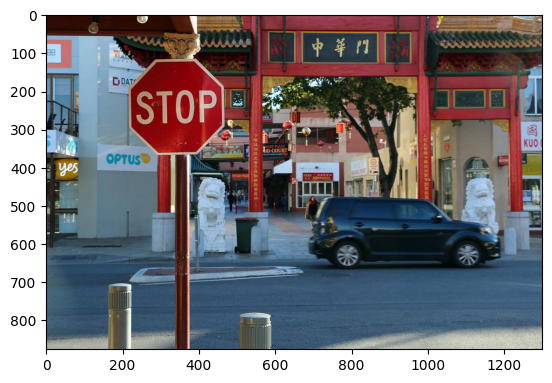

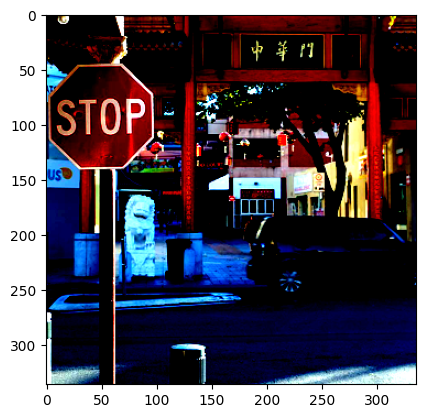

In [ ]:
import matplotlib.pyplot as plt
img = inputs.pixel_values.squeeze().permute(1,2,0)
plt.figure(121),plt.imshow(image)
plt.figure(122),plt.imshow(img)